# Crisis Response
Use this notebook to explore, clean, and perform model training on San Diego Police Crisis Response data.

Author(s): Bryan Flores, Katie Hu, Michael Nguyen

In [101]:
''' Dependencies '''

import pandas as pd
import numpy as np
import os
import pathlib
from pathlib import Path
import glob
import seaborn as sns
import pickle
import boto3
import matplotlib.pyplot as plt

from sagemaker import get_execution_role
role = get_execution_role

from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier ,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from hyperopt import hp, tpe, fmin,STATUS_OK,Trials
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [6]:
def get_csv(type):
    """
    Import CSVs and convert to a list of dataframes.
    :param type: data type to be converted.
    :return: list of dataframes
    """
    path = Path('./data/{}_data'.format(type))
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    df_list = [pd.read_csv(file) for file in csv_files]
    
    return df_list

In [7]:
# Get Source Data
df_list = get_csv('source')

serv_calls_23 = df_list[0]
serv_calls_22 = df_list[1]

In [54]:
# Get Support Data
df_list = get_csv('support')

beat_codes = df_list[1]
disp_codes = df_list[2]
call_codes = df_list[3]

## Exploratory Analysis

### Service Call Table Examination

In [9]:
serv_calls_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499256 entries, 0 to 499255
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   incident_num               499256 non-null  object 
 1   date_time                  499256 non-null  object 
 2   day_of_week                499256 non-null  int64  
 3   address_number_primary     499256 non-null  int64  
 4   address_dir_primary        23135 non-null   object 
 5   address_road_primary       499187 non-null  object 
 6   address_sfx_primary        455019 non-null  object 
 7   address_dir_intersecting   0 non-null       float64
 8   address_road_intersecting  85382 non-null   object 
 9   address_sfx_intersecting   0 non-null       float64
 10  call_type                  498640 non-null  object 
 11  disposition                497161 non-null  object 
 12  beat                       499256 non-null  int64  
 13  priority                   49

In [10]:
serv_calls_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93017 entries, 0 to 93016
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   incident_num               93017 non-null  object 
 1   date_time                  93017 non-null  object 
 2   day_of_week                93017 non-null  int64  
 3   address_number_primary     93017 non-null  int64  
 4   address_dir_primary        4504 non-null   object 
 5   address_road_primary       93005 non-null  object 
 6   address_sfx_primary        84748 non-null  object 
 7   address_dir_intersecting   0 non-null      float64
 8   address_road_intersecting  15173 non-null  object 
 9   address_sfx_intersecting   0 non-null      float64
 10  call_type                  92929 non-null  object 
 11  disposition                92738 non-null  object 
 12  beat                       93017 non-null  int64  
 13  priority                   93017 non-null  int

In [11]:
# Examining the Primary Address fields
adp_df = pd.DataFrame({'adp': [], 'adp_len': []})

adp_df['anp'] = serv_calls_22['address_number_primary'].where(serv_calls_22['address_dir_primary'].notnull())
adp_df['adp'] = serv_calls_22['address_dir_primary'].dropna(axis=0, inplace=False)
adp_df['adp_len'] = adp_df['adp'].str.len()
adp_df['arp'] = serv_calls_22['address_road_primary'].where(serv_calls_22['address_dir_primary'].notnull())
adp_df['asp'] = serv_calls_22['address_sfx_primary'].where(serv_calls_22['address_dir_primary'].notnull())

adp_df.dropna(inplace=True)

In [12]:
adp_df.head()

,adp,adp_len,anp,arp,asp
66,S,1.0,400.0,46TH,ST
191,S,1.0,900.0,30TH,ST
209,S,1.0,0.0,30TH,ST
219,E,1.0,700.0,SAN YSIDRO,BLV
244,S,1.0,0.0,FRANCIS,ST


In [13]:
# Examining the Intersecting Address fields
aip_df = pd.DataFrame({})

aip_df['adi'] = serv_calls_22['address_road_intersecting'].dropna(axis=0, inplace=False)
aip_df['ari'] = serv_calls_22['address_dir_intersecting'].where(serv_calls_22['address_road_intersecting'].notnull())
aip_df['asi'] = serv_calls_22['address_sfx_intersecting'].where(serv_calls_22['address_road_intersecting'].notnull())

aip_df.dropna(inplace=True)

In [14]:
aip_df.head()

,adi,ari,asi


In [15]:
def count_missing(df):
    ''' Count number of missing values for each DF column '''
    na_nums = df.isna().sum()
    na_plot = na_nums.reset_index(name="Count").plot.bar(x='index', y='Count', title='Service Calls', rot=90)
    
    return na_nums, na_plot

(incident_num                      0
 date_time                         0
 day_of_week                       0
 address_number_primary            0
 address_dir_primary          476121
 address_road_primary             69
 address_sfx_primary           44237
 address_dir_intersecting     499256
 address_road_intersecting    413874
 address_sfx_intersecting     499256
 call_type                       616
 disposition                    2095
 beat                              0
 priority                          0
 dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f18fa860b50>)

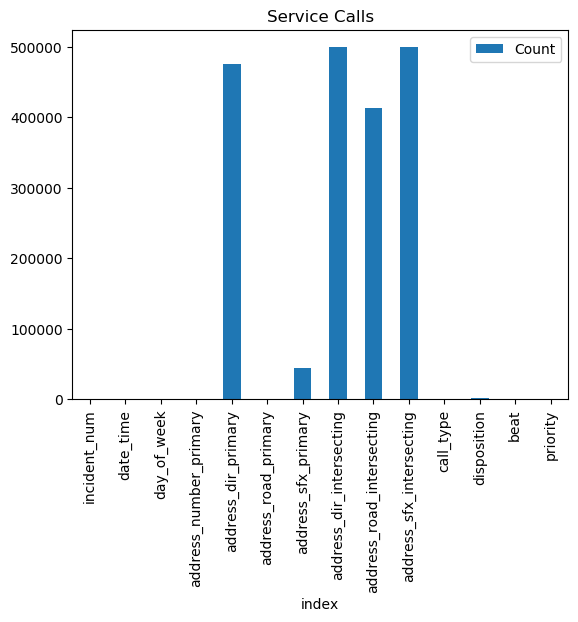

In [16]:
%matplotlib inline 
count_missing(serv_calls_22)

(incident_num                     0
 date_time                        0
 day_of_week                      0
 address_number_primary           0
 address_dir_primary          88513
 address_road_primary            12
 address_sfx_primary           8269
 address_dir_intersecting     93017
 address_road_intersecting    77844
 address_sfx_intersecting     93017
 call_type                       88
 disposition                    279
 beat                             0
 priority                         0
 dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f18fa710410>)

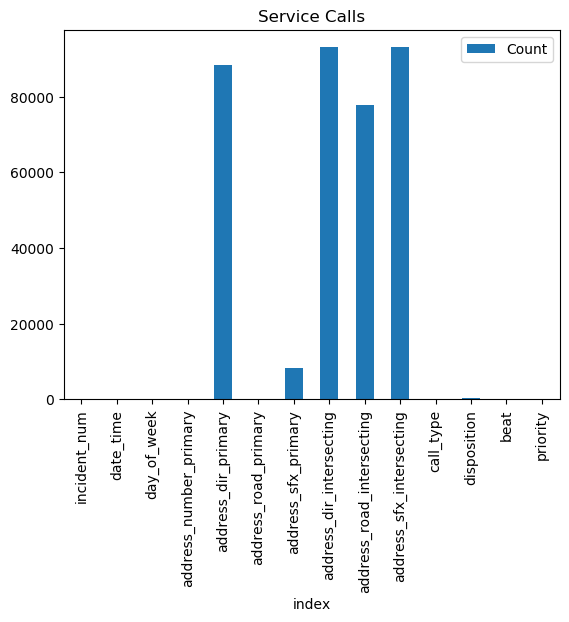

In [17]:
%matplotlib inline 
count_missing(serv_calls_23)

In [18]:
# List all the neighborhoods in San Diego

beat_codes['neighborhood'].unique()

array(['Clairemont Mesa East', 'Clairemont Mesa West', 'Bay Ho',
       'North Clairemont', 'University City', 'Bay Park', 'Mission Beach',
       'Pacific Beach', 'Mission Bay Park', 'La Jolla', 'Torrey Pines',
       'Sabre Springs', 'Carmel Mountain', 'Rancho Penasquitos',
       'Rancho Bernardo', 'San Pasqual', 'Scripps Ranch', 'Mira Mesa',
       'Miramar', 'Rancho Encantada', 'Miramar Ranch North', 'Serra Mesa',
       'Tierrasanta', 'Kearny Mesa', 'Birdland', 'Mission Valley East',
       'Qualcomm', 'Grantville', 'Allied Gardens', 'Del Cerro',
       'Lake Murray', 'San Carlos', 'College West', 'College East',
       'Emerald Hills', 'Valencia Park', 'Encanto', 'Jamacha/Lomita',
       'Broadway Heights', 'Skyline', 'Bay Terraces', 'Paradise Hills',
       'Alta Vista', 'Mountain View', 'Southcrest', 'Shelltown',
       'Mt. Hope', 'Chollas View', 'Lincoln Park', 'Ridgeview/Webster',
       'Oak Park', "O'Farrell", 'Barrio Logan', 'Logan Heights',
       'Sherman Heights', 'Gr

In [19]:
# List all the neighborhoods in San Diego

call_codes['description'].unique()

array(['DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ONSCENE',
       'ARREST MADE', 'ARREST MADE, BOARD AND SECURE',
       'ARREST MADE, HIGH RISK (CRISIS RESPONSE TEAM)', 'REPORT',
       'REPORT TAKEN, BOARD AND SECURE',
       'REPORT, HIGH RISK (CRISIS RESPONSE TEAM)',
       'STOLEN VEHICLE OR RECOVERED VEHICLE', 'OTHER',
       'OTHER, HIGH RISK (CRISIS RESPONSE TEAM)', 'NO REPORT REQUIRED',
       'NO REPORT REQUIRED, BOARD AND SECURE',
       'NO FURTHER ACTION, HIGH RISK (CRISIS RESPONSE TEAM)', 'UNFOUNDED',
       'NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISPATCHING A UNIT',
       'CANCEL', "DUPLICATE CALL, XREF'D", 'DUPLICATE CALL'], dtype=object)

Selected Call Type Codes

* 5150 - Mental Health
* 5150V - Mental Health - Violent or Urgent
* FS - Found Senile
* Rescue - Rescue Citizens

In [20]:
# Call Type Codes related to substance abuse, mental health, suicide

crisis_response = ['5150', '5150V', 'FS', 'RESCUE']

# Select Rows containing these call type codes
cr_df = serv_calls_22[serv_calls_22['call_type'].isin(crisis_response)]

In [21]:
# Look into distribution of call types related to substance abuse, mental health, and suicide response


# sns.histplot(data = cr_df, x = 'call_type')

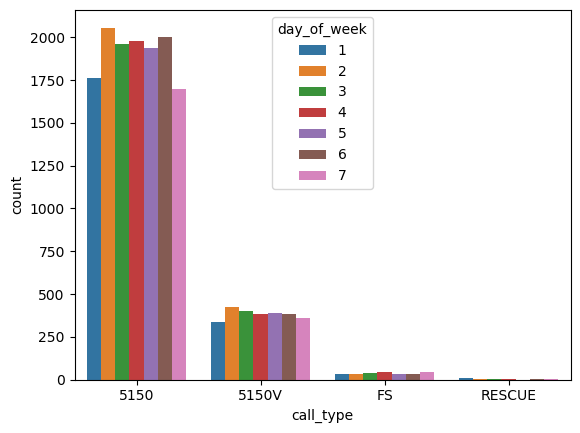

In [22]:
# Look into if calls fluctuate based on the day of week

sns.countplot(x= 'call_type', hue = 'day_of_week', data = cr_df)

In [23]:
# Show Number of Call Types for the crisis response codes

cr_df['call_type'].value_counts().to_frame()

,call_type
5150,13406
5150V,2676
FS,261
RESCUE,24


In [24]:
# Find which neighborhoods have the most call

cr_df['beat'].value_counts().to_frame()

,beat
521,1220
524,666
627,521
242,454
122,389
...,...
617,4
435,3
235,1
0,1


In [25]:
beat_codes.dtypes

beat             int64
neighborhood    object
zipcode          int64
region          object
region_id        int64
dtype: object

In [26]:
# Find which neighborhoods have the highest calls

top_areas_of_cf_calls = [521, 524, 627, 242, 122]

print(beat_codes[beat_codes['beat'].isin(top_areas_of_cf_calls)])

    beat   neighborhood  zipcode         region  region_id
7    122  Pacific Beach    92109  North Central          3
17   242      Mira Mesa    92126  North Central          3
59   521   East Village    92101        Central          5
62   524  Core-Columbia    92101        Central          5
84   627      Hillcrest    92103        Central          5


In [27]:
# Group by General Neighborhood Areas for Better Visualization
b_codes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
b_neighborhoods = ['100s', '200s', '300s', '400s', '500s', '600s', '700s', '800s', '900s']

cr_df['grouped_neighborhoods'] = pd.cut(cr_df['beat'], bins = b_codes, labels = b_neighborhoods, include_lowest = True)
cr_df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority,grouped_neighborhoods
138,E22010000145,2022-01-01 01:11:19,7,3200,NaN,COWLEY,WAY,NaN,NaN,NaN,5150,CAN,116,2,100s
172,E22010000183,2022-01-01 01:33:06,7,9100,NaN,HUNTINGTON,AVE,NaN,NaN,NaN,5150V,K,311,1,300s
177,E22010000188,2022-01-01 01:38:21,7,900,NaN,05TH,AVE,NaN,NaN,NaN,5150,CAN,523,2,500s
223,E22010000237,2022-01-01 02:13:26,7,6700,NaN,THORNWOOD,ST,NaN,NaN,NaN,5150,K,111,2,100s
329,E22010000350,2022-01-01 03:34:26,7,2000,NaN,VESTA,ST,NaN,NaN,NaN,5150,CAN,511,2,500s


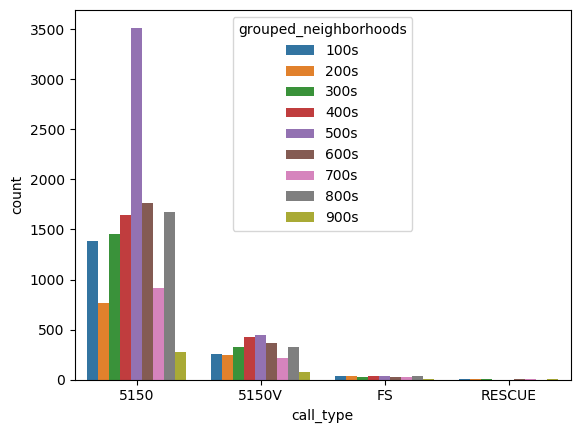

In [28]:
# Call Types by Grouped Neighborhoods 

sns.countplot(x= 'call_type', hue = 'grouped_neighborhoods', data = cr_df)

In [29]:
# Distribution of Calls by Neighborhoods

# sns.histplot(data = cr_df, x = 'grouped_neighborhoods')

Downtown San Diego, specifically in East Village has the highest calls related to substance abuse, mental health, and suicide response.

## Data Cleaning: Service Calls


In [30]:
# Perform a Union All on the Service Call tables

frames = [serv_calls_22, serv_calls_23]

serv_calls_union = pd.concat(frames)

In [31]:
serv_calls_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592273 entries, 0 to 93016
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   incident_num               592273 non-null  object 
 1   date_time                  592273 non-null  object 
 2   day_of_week                592273 non-null  int64  
 3   address_number_primary     592273 non-null  int64  
 4   address_dir_primary        27639 non-null   object 
 5   address_road_primary       592192 non-null  object 
 6   address_sfx_primary        539767 non-null  object 
 7   address_dir_intersecting   0 non-null       float64
 8   address_road_intersecting  100555 non-null  object 
 9   address_sfx_intersecting   0 non-null       float64
 10  call_type                  591569 non-null  object 
 11  disposition                589899 non-null  object 
 12  beat                       592273 non-null  int64  
 13  priority                   592

In [32]:
# Drop rows with NaN for columns: call_type & disposition

serv_calls_dropna = serv_calls_union.dropna(subset=['call_type', 'disposition'])
serv_calls_dropna.reset_index(drop=True)

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E22010000001,2022-01-01 00:00:00,7,1300,NaN,MORAEA,ST,NaN,NaN,NaN,AU1,DUP,452,1
1,E22010000002,2022-01-01 00:00:07,7,600,NaN,BROADWAY,NaN,NaN,NaN,NaN,1186,CAN,524,3
2,E22010000003,2022-01-01 00:00:08,7,700,NaN,GRAND,AVE,NaN,NaN,NaN,1186,K,122,3
3,E22010000004,2022-01-01 00:00:15,7,4600,NaN,AIR,WAY,NaN,NaN,NaN,MPSSTP,K,447,2
4,E22010000005,2022-01-01 00:00:22,7,4700,NaN,MISSION BAY,DR,NaN,NaN,NaN,AU1,DUP,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589191,E23030015126,2023-03-10 23:41:30,6,4400,NaN,MISSION,BLV,NaN,NaN,NaN,T,K,122,2
589192,E23030015127,2023-03-10 23:43:08,6,0,NaN,EL CAJON,BLV,NaN,CHAMOUNE,NaN,CW,K,831,1
589193,E23030015130,2023-03-10 23:46:11,6,2500,NaN,IMPERIAL,AVE,NaN,NaN,NaN,1021,CAN,512,3
589194,E23030015132,2023-03-10 23:47:37,6,1500,NaN,THOMAS,AVE,NaN,NaN,NaN,415,K,122,2


In [33]:
serv_calls_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589196 entries, 0 to 93016
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   incident_num               589196 non-null  object 
 1   date_time                  589196 non-null  object 
 2   day_of_week                589196 non-null  int64  
 3   address_number_primary     589196 non-null  int64  
 4   address_dir_primary        27511 non-null   object 
 5   address_road_primary       589115 non-null  object 
 6   address_sfx_primary        537152 non-null  object 
 7   address_dir_intersecting   0 non-null       float64
 8   address_road_intersecting  100506 non-null  object 
 9   address_sfx_intersecting   0 non-null       float64
 10  call_type                  589196 non-null  object 
 11  disposition                589196 non-null  object 
 12  beat                       589196 non-null  int64  
 13  priority                   589

In [34]:
# Drop Address Intersection fields

serv_calls_dropcols = serv_calls_dropna.drop(columns=['address_dir_intersecting', 
                                                      'address_road_intersecting', 
                                                      'address_sfx_intersecting'])

In [35]:
serv_calls_dropcols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589196 entries, 0 to 93016
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   incident_num            589196 non-null  object
 1   date_time               589196 non-null  object
 2   day_of_week             589196 non-null  int64 
 3   address_number_primary  589196 non-null  int64 
 4   address_dir_primary     27511 non-null   object
 5   address_road_primary    589115 non-null  object
 6   address_sfx_primary     537152 non-null  object
 7   call_type               589196 non-null  object
 8   disposition             589196 non-null  object
 9   beat                    589196 non-null  int64 
 10  priority                589196 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 53.9+ MB


In [36]:
# Split date_time column into 2 separate fields

serv_calls_dt = serv_calls_dropcols
serv_calls_dt['date_pst'] = pd.to_datetime(serv_calls_dt['date_time']).dt.date
serv_calls_dt['time_pst'] = pd.to_datetime(serv_calls_dt['date_time']).dt.time

In [37]:
# Join Beat Codes on Service Call Table

serv_calls_bn = serv_calls_dt
serv_calls_bn = serv_calls_bn.merge(beat_codes, how="left", on="beat").reset_index(drop=True)

In [38]:
serv_calls_bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589196 entries, 0 to 589195
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   incident_num            589196 non-null  object 
 1   date_time               589196 non-null  object 
 2   day_of_week             589196 non-null  int64  
 3   address_number_primary  589196 non-null  int64  
 4   address_dir_primary     27511 non-null   object 
 5   address_road_primary    589115 non-null  object 
 6   address_sfx_primary     537152 non-null  object 
 7   call_type               589196 non-null  object 
 8   disposition             589196 non-null  object 
 9   beat                    589196 non-null  int64  
 10  priority                589196 non-null  int64  
 11  date_pst                589196 non-null  object 
 12  time_pst                589196 non-null  object 
 13  neighborhood            580061 non-null  object 
 14  zipcode             

In [39]:
serv_calls_missing = serv_calls_bn[serv_calls_bn['neighborhood'].isnull()]
serv_calls_missing

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,priority,date_pst,time_pst,neighborhood,zipcode,region,region_id
10,E22010000011,2022-01-01 00:02:44,7,0,NaN,STATE ROUTE 163 NB,NaN,MPSSTP,K,-1,2,2022-01-01,00:02:44,NaN,NaN,NaN,NaN
13,E22010000014,2022-01-01 00:04:38,7,0,NaN,INFO LOG,NaN,503CAR,W,-1,2,2022-01-01,00:04:38,NaN,NaN,NaN,NaN
18,E22010000019,2022-01-01 00:05:44,7,0,NaN,CHP INFO LOG,NaN,INFOCHP,W,-1,4,2022-01-01,00:05:44,NaN,NaN,NaN,NaN
19,E22010000020,2022-01-01 00:06:12,7,0,NaN,MCRT INFO LOG,NaN,INFO,W,-1,2,2022-01-01,00:06:12,NaN,NaN,NaN,NaN
24,E22010000025,2022-01-01 00:07:01,7,0,NaN,SHOPS INFO LOG,NaN,SHOPS,W,-1,4,2022-01-01,00:07:01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589046,E23030014903,2023-03-10 20:20:33,6,3700,NaN,43RD,ST,MPSSTP,K,-1,2,2023-03-10,20:20:33,NaN,NaN,NaN,NaN
589094,E23030014969,2023-03-10 21:21:21,6,3500,NaN,CANNON,RD,AU1,W,-1,1,2023-03-10,21:21:21,NaN,NaN,NaN,NaN
589096,E23030014971,2023-03-10 21:23:21,6,0,NaN,I-8 EB OFF RAMP,NaN,AU1,W,-1,1,2023-03-10,21:23:21,NaN,NaN,NaN,NaN
589097,E23030014972,2023-03-10 21:25:16,6,1300,NaN,ORO,ST,10852,CAN,-1,1,2023-03-10,21:25:16,NaN,NaN,NaN,NaN


In [40]:
serv_calls_bn['neighborhood'].isna().sum()

9135

In [41]:
serv_calls_bn['beat'].unique()

array([452, 524, 122, 447, 321, 621, 451, 813, 834,  -1, 811, 441, 432,
       114, 437, 515, 233, 511, 934, 526, 523, 836, 837, 111, 431, 433,
       712, 624, 326, 443, 622, 434, 611, 529, 121, 242, 935, 444, 234,
       613, 115, 832, 822, 723, 516, 831, 614, 627, 725, 827, 518, 436,
       937, 327, 512, 931, 821, 124, 521, 522, 241, 724, 612, 313, 722,
       116, 626, 615, 438, 833, 628, 311, 312, 721, 933, 838, 446, 826,
       315, 713, 714, 623, 112, 525, 541, 514, 517, 528, 325, 841, 824,
       527, 323, 823, 314, 113, 936, 828, 322, 445, 243, 531, 932, 839,
       231, 616, 235, 123, 232, 835, 324, 825, 625, 814, 442, 829, 126,
       246, 618, 439, 617, 711, 435, 316, 245, 812,   9, 700, 300,   0])

* Attempted to use a right join making the assumption that all beat codes in the reference table are found in the service call table.
    * This is not the case.
    * The total number of rows drops by the above value to 580061.
* By using a left join, we maintain the same number of rows, but some neighborhoods will not be accounted for.

Therefore, we will need to find more information on the beat codes that are not included in the reference as the beat_code column has 0 null values.

### Ordering Service Calls by Priority

In [42]:
# Priority Order

# Find unique values of priority

print(serv_calls_bn['priority'].unique())

[1 3 2 4 0 9 5 8]


In [43]:
# No Priority Code exists for 5 and 8, therefore it is an error and should be dropped
p = [5, 8]
print(serv_calls_bn[serv_calls_bn['priority'].isin(p)])

# Drop Error Priority Code
serv_calls_bn = serv_calls_bn[serv_calls_bn['priority'].isin(p) == False]

        incident_num            date_time  day_of_week  \
29810   E22010032150  2022-01-23 14:34:09            1   
36032   E22010038843  2022-01-28 03:55:45            6   
37621   E22010040535  2022-01-29 05:45:53            7   
262737  E22070013676  2022-07-10 04:03:59            1   
293942  E22080002349  2022-08-02 13:42:16            3   
570499  E23020036542  2023-02-25 09:00:49            7   
578284  E23030003352  2023-03-03 06:46:28            6   

        address_number_primary address_dir_primary address_road_primary  \
29810                        0                 NaN                524Y2   
36032                    11400                 NaN   NORTH TORREY PINES   
37621                    11400                 NaN   NORTH TORREY PINES   
262737                     600                 NaN                    K   
293942                       0                 NaN                811B1   
570499                    1000                 NaN                 10TH   
578284    

In [44]:
# Verified that no anomalies are present in the priority

print(serv_calls_bn['priority'].unique())

[1 3 2 4 0 9]


In [56]:
# Import Disposition descriptions and merge on the disposition field

disp_codes = disp_codes.rename(columns={'dispo_code': 'disposition', 'description': 'disp_description'})

serv_calls_disp = serv_calls_bn

In [57]:
disp_codes.head()

,disposition,disp_description
0,X,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...
1,A,ARREST MADE
2,AB,"ARREST MADE, BOARD AND SECURE"
3,AHR,"ARREST MADE, HIGH RISK (CRISIS RESPONSE TEAM)"
4,R,REPORT


In [58]:
# Disposition Codes Binned into Arrests, Report, Stolen Vehicle, Other, No Report, and Duplicate/Cancel

disp_codes['disp_category'] = disp_codes['disposition'].replace({'A': 'Arrests', 'AB': 'Arrests', 'AHR': 'Arrests',
                                                                'R': 'Report', 'RB': 'Report', 'RHR': 'Report', 'S': 'Stolen Vehicle', 
                                                                'O': 'Other', 'OHR': 'Other', 'K': 'No Report', 'KB': 'No Report', 'KHR': 'No Report', 'U': 'No Report', 
                                                                'W': 'Duplicate/Cancel', 'CAN': 'Duplicate/Cancel', 'DUP': 'Duplicate/Cancel', 'V': 'Duplicate/Cancel', 'X': 'Duplicate/Cancel'})

In [59]:
disp_codes['disp_category_id'] = disp_codes['disp_category'].replace({'Arrests': '0', 'Report': '1', 
                                                                      'Stolen Vehicle': '2', 'Other': '3', 
                                                                      'No Report': '4', 'Duplicate/Cancel': '5'})

In [60]:
disp_codes.head()

,disposition,disp_description,disp_category,disp_category_id
0,X,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
1,A,ARREST MADE,Arrests,0
2,AB,"ARREST MADE, BOARD AND SECURE",Arrests,0
3,AHR,"ARREST MADE, HIGH RISK (CRISIS RESPONSE TEAM)",Arrests,0
4,R,REPORT,Report,1


In [61]:
serv_calls_disp = serv_calls_disp.merge(disp_codes, how="right", on="disposition")
serv_calls_disp

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,priority,date_pst,time_pst,neighborhood,zipcode,region,region_id,disp_description,disp_category,disp_category_id
0,E22010002265,2022-01-02 17:25:52,1.0,0.0,NaN,NORTH HARBOR,DR,1183,X,615.0,0.0,2022-01-02,17:25:52,Roseville/Fleet Ridge,92106.0,North Central,3.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
1,E22010002371,2022-01-02 19:04:59,1.0,2600.0,NaN,28TH,ST,459A,X,813.0,2.0,2022-01-02,19:04:59,North Park,92104.0,Central,5.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
2,E22010002374,2022-01-02 19:08:06,1.0,2400.0,NaN,SAN DIEGO,AVE,415,X,625.0,2.0,2022-01-02,19:08:06,Old Town,92110.0,North Central,3.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
3,E22010002762,2022-01-03 03:25:16,2.0,17700.0,NaN,AZUCAR,WAY,459A,X,234.0,2.0,2022-01-03,03:25:16,Rancho Bernardo,92129.0,North Inland,2.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
4,E22010004893,2022-01-04 15:20:04,3.0,6500.0,NaN,MISSION GORGE,RD,459A,X,321.0,1.0,2022-01-04,15:20:04,Grantville,92120.0,North Central,3.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589148,E22060026014,2022-06-18 15:50:56,7.0,5300.0,NaN,BONITA,DR,1186,V,432.0,3.0,2022-06-18,15:50:56,Valencia Park,92114.0,Central,5.0,DUPLICATE CALL,Duplicate/Cancel,5
589149,E22080031811,2022-08-22 13:48:34,2.0,0.0,NaN,NOBEL,DR,SLEEPER,V,124.0,3.0,2022-08-22,13:48:34,La Jolla,92037.0,North Central,3.0,DUPLICATE CALL,Duplicate/Cancel,5
589150,E22080035551,2022-08-25 00:59:29,5.0,0.0,NaN,VILLA LA JOLLA,DR,SLEEPER,V,124.0,3.0,2022-08-25,00:59:29,La Jolla,92037.0,North Central,3.0,DUPLICATE CALL,Duplicate/Cancel,5
589151,E22090002754,2022-09-02 17:15:03,6.0,1200.0,NaN,03RD,AVE,MPSSTP,V,524.0,2.0,2022-09-02,17:15:03,Core-Columbia,92101.0,Central,5.0,DUPLICATE CALL,Duplicate/Cancel,5


In [62]:
serv_calls_disp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589153 entries, 0 to 589152
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   incident_num            589152 non-null  object 
 1   date_time               589152 non-null  object 
 2   day_of_week             589152 non-null  float64
 3   address_number_primary  589152 non-null  float64
 4   address_dir_primary     27506 non-null   object 
 5   address_road_primary    589071 non-null  object 
 6   address_sfx_primary     537117 non-null  object 
 7   call_type               589152 non-null  object 
 8   disposition             589153 non-null  object 
 9   beat                    589152 non-null  float64
 10  priority                589152 non-null  float64
 11  date_pst                589152 non-null  object 
 12  time_pst                589152 non-null  object 
 13  neighborhood            580021 non-null  object 
 14  zipcode             

In [63]:
# Merge Call Code descriptions  on the call code type description
call_codes = call_codes.rename(columns={'description': 'call_code_description'})

In [64]:
call_codes = call_codes.drop(columns=['Unnamed: 2'])

In [65]:
serv_calls_callcodes = serv_calls_disp
serv_calls_callcodes = serv_calls_callcodes.merge(call_codes, how="right", on="call_type")
serv_calls_callcodes

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,...,neighborhood,zipcode,region,region_id,disp_description,disp_category,disp_category_id,call_code_description,Unnamed: 3,Unnamed: 4
0,E22110034378,2022-11-25 08:39:48,6.0,9400.0,NaN,MIRAMAR,RD,1016,X,243.0,...,Miramar,92145.0,North Central,3.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5,PRISONER IN CUSTODY,NaN,NaN
1,E23020035394,2023-02-24 13:45:07,6.0,3100.0,NaN,SPORTS ARENA,BLV,1016,X,611.0,...,Midway District,92199.0,North Central,3.0,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5,PRISONER IN CUSTODY,NaN,NaN
2,E22010000119,2022-01-01 00:48:37,7.0,600.0,NaN,05TH,AVE,1016,A,523.0,...,Gaslamp,92101.0,Central,5.0,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
3,E22010000156,2022-01-01 01:18:03,7.0,600.0,NaN,05TH,AVE,1016,A,523.0,...,Gaslamp,92101.0,Central,5.0,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
4,E22010000177,2022-01-01 01:27:54,7.0,800.0,NaN,05TH,AVE,1016,A,523.0,...,Gaslamp,92101.0,Central,5.0,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644374,E22070038154,2022-07-27 05:52:26,4.0,300.0,NaN,LOS ANGELES,PL,WARRANT,DUP,432.0,...,Valencia Park,92114.0,Central,5.0,"DUPLICATE CALL, XREF'D",Duplicate/Cancel,5,WARRANT,NaN,NaN
644375,E22090041347,2022-09-28 17:12:27,4.0,100.0,W,C,ST,WARRANT,DUP,524.0,...,Core-Columbia,92101.0,Central,5.0,"DUPLICATE CALL, XREF'D",Duplicate/Cancel,5,WARRANT,NaN,NaN
644376,E23010024097,2023-01-18 02:47:56,4.0,1400.0,NaN,BROADWAY,NaN,WARRANT,DUP,521.0,...,East Village,92101.0,Central,5.0,"DUPLICATE CALL, XREF'D",Duplicate/Cancel,5,WARRANT,NaN,NaN
644377,E23010025622,2023-01-19 01:35:25,5.0,4200.0,NaN,TOLOWA,ST,WARRANT,DUP,114.0,...,North Clairemont,92117.0,North Central,3.0,"DUPLICATE CALL, XREF'D",Duplicate/Cancel,5,WARRANT,NaN,NaN


In [66]:
serv_calls_callcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644379 entries, 0 to 644378
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   incident_num            644334 non-null  object 
 1   date_time               644334 non-null  object 
 2   day_of_week             644334 non-null  float64
 3   address_number_primary  644334 non-null  float64
 4   address_dir_primary     29810 non-null   object 
 5   address_road_primary    644251 non-null  object 
 6   address_sfx_primary     588822 non-null  object 
 7   call_type               644379 non-null  object 
 8   disposition             644334 non-null  object 
 9   beat                    644334 non-null  float64
 10  priority                644334 non-null  float64
 11  date_pst                644334 non-null  object 
 12  time_pst                644334 non-null  object 
 13  neighborhood            635174 non-null  object 
 14  zipcode             

In [67]:
serv_calls_missing_neigborhood = serv_calls_callcodes[serv_calls_callcodes['neighborhood'].isnull()]
serv_calls_missing_neigborhood

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,call_type,disposition,beat,...,neighborhood,zipcode,region,region_id,disp_description,disp_category,disp_category_id,call_code_description,Unnamed: 3,Unnamed: 4
14,E22010001162,2022-01-01 19:03:06,7.0,800.0,NaN,ETA,ST,1016,A,-1.0,...,NaN,NaN,NaN,NaN,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
60,E22010007772,2022-01-06 14:00:57,5.0,0.0,NB,805,NaN,1016,A,-1.0,...,NaN,NaN,NaN,NaN,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
78,E22010010958,2022-01-08 22:17:19,7.0,8400.0,NaN,PARADISE VALLEY,RD,1016,A,-1.0,...,NaN,NaN,NaN,NaN,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
83,E22010011942,2022-01-09 17:44:45,1.0,8200.0,NaN,BLUFFVIEW,CT,1016,A,-1.0,...,NaN,NaN,NaN,NaN,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
100,E22010014499,2022-01-11 15:24:09,3.0,0.0,NB,15,NaN,1016,A,-1.0,...,NaN,NaN,NaN,NaN,ARREST MADE,Arrests,0,PRISONER IN CUSTODY,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644346,E22100028789,2022-10-20 05:44:34,5.0,13300.0,NaN,LOS COCHES,RD,WARRANT,W,-1.0,...,NaN,NaN,NaN,NaN,NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISP...,Duplicate/Cancel,5,WARRANT,NaN,NaN
644351,E23020001386,2023-02-01 19:33:41,4.0,400.0,NaN,ROOSEVELT,AVE,WARRANT,W,-1.0,...,NaN,NaN,NaN,NaN,NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISP...,Duplicate/Cancel,5,WARRANT,NaN,NaN
644354,E23020033588,2023-02-23 10:21:23,5.0,1200.0,NaN,GRANDVIEW,RD,WARRANT,W,-1.0,...,NaN,NaN,NaN,NaN,NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISP...,Duplicate/Cancel,5,WARRANT,NaN,NaN
644356,E23020041371,2023-02-28 20:08:35,3.0,18900.0,NaN,OLD COACH,WAY,WARRANT,W,-1.0,...,NaN,NaN,NaN,NaN,NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISP...,Duplicate/Cancel,5,WARRANT,NaN,NaN


## Training Data Preparation

In [68]:
prep_df = pd.read_csv('data/staging_data/service_calls_cleaned.csv')
beat_df = pd.read_csv('data/support_data/pd_beat_codes_expanded.csv')

In [69]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635507 entries, 0 to 635506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              635507 non-null  int64  
 1   incident_num            635459 non-null  object 
 2   date_time               635459 non-null  object 
 3   day_of_week             635459 non-null  float64
 4   address_number_primary  635459 non-null  float64
 5   address_dir_primary     29460 non-null   object 
 6   address_road_primary    635376 non-null  object 
 7   address_sfx_primary     580457 non-null  object 
 8   call_type               635507 non-null  object 
 9   disposition             635459 non-null  object 
 10  beat                    635459 non-null  float64
 11  priority                635459 non-null  float64
 12  date_pst                635459 non-null  object 
 13  time_pst                635459 non-null  object 
 14  neighborhood        

In [70]:
# Joining Beat Codes Expanded to Obtain Region IDs
prep_df = prep_df.merge(beat_df, how="left", on="beat").reset_index(drop=True)

In [71]:
prep_df.head()

,Unnamed: 0,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,call_type,disposition,...,time_pst,neighborhood_x,disp_description,disp_category,disp_category_id,call_code_description,neighborhood_y,zipcode,region,region_id
0,0,E22110034378,2022-11-25 08:39:48,6.0,9400.0,NaN,MIRAMAR,RD,1016,X,...,08:39:48,Miramar,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5.0,PRISONER IN CUSTODY,Miramar,92145.0,North Central,3.0
1,1,E23020035394,2023-02-24 13:45:07,6.0,3100.0,NaN,SPORTS ARENA,BLV,1016,X,...,13:45:07,Midway District,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...,Duplicate/Cancel,5.0,PRISONER IN CUSTODY,Midway District,92199.0,North Central,3.0
2,2,E22010000119,2022-01-01 00:48:37,7.0,600.0,NaN,05TH,AVE,1016,A,...,00:48:37,Gaslamp,ARREST MADE,Arrests,0.0,PRISONER IN CUSTODY,Gaslamp,92101.0,Central,5.0
3,3,E22010000156,2022-01-01 01:18:03,7.0,600.0,NaN,05TH,AVE,1016,A,...,01:18:03,Gaslamp,ARREST MADE,Arrests,0.0,PRISONER IN CUSTODY,Gaslamp,92101.0,Central,5.0
4,4,E22010000177,2022-01-01 01:27:54,7.0,800.0,NaN,05TH,AVE,1016,A,...,01:27:54,Gaslamp,ARREST MADE,Arrests,0.0,PRISONER IN CUSTODY,Gaslamp,92101.0,Central,5.0


In [72]:
"""
Drop columns:
:col "Unnamed: 0": additional index column from second merge
:col neighborhood_x: duplicated neighborhood column
:col neighborhood_y: duplicated neighborhood column
:col zipcode: determines region
:col region: determines region_id
:col address_road_primary:
:col address_number_primary:
:col address_dir_primary:
:col address_sfx_primary:
:col date_time:
:col disp_description:
:col disp_category:
:col call_code_description:
:col disposition:
"""
prep_df = prep_df.drop(columns=["Unnamed: 0", "neighborhood_x", "neighborhood_y", 
                      "zipcode", "region", "address_road_primary",
                      "address_number_primary", "address_dir_primary", "address_sfx_primary",
                      "date_time", "disp_description", "disp_category", "call_code_description", "disposition"])

In [73]:
# Drop Remaining Rows where null values are present
prep_df = prep_df.dropna()

In [74]:
# Convert Data Types 

prep_df[['day_of_week', 'beat', 'priority', 'disp_category_id', 'region_id']] = prep_df[['day_of_week', 'beat', 'priority', 'disp_category_id', 'region_id']].astype(int)
prep_df[['incident_num']] = prep_df[['incident_num']].astype(str)

In [75]:
# Remove First Letter E from Column
prep_df['incident_num'] = prep_df['incident_num'].str[1:]

# Convert Data Type to Int
prep_df[['incident_num']] = prep_df[['incident_num']].astype(int)

In [76]:
# Verify Data Types are Correct
prep_df.dtypes

incident_num         int64
day_of_week          int64
call_type           object
beat                 int64
priority             int64
date_pst            object
time_pst            object
disp_category_id     int64
region_id            int64
dtype: object

In [77]:
# Priority Order
# Find unique values of priority
print(prep_df['priority'].unique())

[2 1 0 3 9 4]


In [78]:
# Call Type Codes related to substance abuse, mental health, suicide
crisis_response = ['5150', '5150V', 'FS', 'RESCUE', 'FJ']

# Create new column 0, 1 for codes
prep_df['cr_code'] = np.where(prep_df.call_type.isin(crisis_response),1,0)
prep_df

,incident_num,day_of_week,call_type,beat,priority,date_pst,time_pst,disp_category_id,region_id,cr_code
0,22110034378,6,1016,243,2,2022-11-25,08:39:48,5,3,0
1,23020035394,6,1016,611,2,2023-02-24,13:45:07,5,3,0
2,22010000119,7,1016,523,2,2022-01-01,00:48:37,0,5,0
3,22010000156,7,1016,523,2,2022-01-01,01:18:03,0,5,0
4,22010000177,7,1016,523,2,2022-01-01,01:27:54,0,5,0
...,...,...,...,...,...,...,...,...,...,...
635502,22070038154,4,WARRANT,432,3,2022-07-27,05:52:26,5,5,0
635503,22090041347,4,WARRANT,524,1,2022-09-28,17:12:27,5,5,0
635504,23010024097,4,WARRANT,521,3,2023-01-18,02:47:56,5,5,0
635505,23010025622,5,WARRANT,114,3,2023-01-19,01:35:25,5,3,0


### Training Set CSVs

In [79]:
# All Cleaned Fields
prep_df.to_csv('data/training_data/crisis_resp_train.csv', index = False)

In [80]:
# w/o Time Fields
cr_notime = prep_df.drop(columns=['day_of_week', 'date_pst', 'time_pst'])
cr_notime.to_csv('data/training_data/crisis_resp_nt_train.csv', index = False)

Dropping the following regions: North Coastal, South, and North Inland. These regions make up 13.6% of total Service Call data. Alternatively, North Central & Central account for 86.4% of the data set.

In [81]:
crisis_resp_reg_train = prep_df[prep_df['region_id'].isin([3, 5])]

In [82]:
crisis_resp_reg_train.to_csv('data/training_data/crisis_resp_reg_train.csv', index = False)

## Model Training

### Load Data

In [83]:
data_le = pd.read_csv('data/training_data/crisis_resp_nt_train.csv')

In [84]:
data_le.head()

,incident_num,call_type,beat,priority,disp_category_id,region_id,cr_code
0,22110034378,1016,243,2,5,3,0
1,23020035394,1016,611,2,5,3,0
2,22010000119,1016,523,2,0,5,0
3,22010000156,1016,523,2,0,5,0
4,22010000177,1016,523,2,0,5,0


In [85]:
def modeling(X,Y,model,model_name,random_state):
    """
    Step1 - Dividing the data into train, test, validation sets
    """
    X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1,random_state=random_state)
    X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=random_state)
    
    model.fit(X_train,Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    Y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(Y_train,Y_train_pred)
    val_acc = accuracy_score(Y_val,Y_val_pred)
    test_acc = accuracy_score(Y_test,Y_test_pred)
    
    train_recall = recall_score(Y_train,Y_train_pred,average="weighted")
    val_recall = recall_score(Y_val,Y_val_pred,average="weighted")
    test_recall = recall_score(Y_test,Y_test_pred,average="weighted")
    
    train_precision = precision_score(Y_train,Y_train_pred,average="weighted")
    val_precision = precision_score(Y_val,Y_val_pred,average="weighted")
    test_precision = precision_score(Y_test,Y_test_pred,average="weighted")
    
    train_f1 = f1_score(Y_train,Y_train_pred,average="weighted")
    val_f1 = f1_score(Y_val,Y_val_pred,average="weighted")
    test_f1 = f1_score(Y_test,Y_test_pred,average="weighted")
    
    df = pd.DataFrame({"TrainAccuracy":train_acc,"ValidationAccuracy":val_acc,"TestAccuracy":test_acc,
                       "TrainPrecision":train_precision,"ValidationPrecision":val_precision,"TestPrecision":test_precision,
                       "TrainRecall":train_recall,"ValidationRecall":val_recall,"TestRecall":test_recall,
                       "TrainF1":train_f1,"ValidationF1":val_f1,"TestF1":test_f1},
                     index = [model_name])
    
    return df

### Modeling For Label Encoding Data

In [86]:
data_le_X = data_le.drop(columns=["cr_code", "call_type"])
data_le_Y = data_le[["cr_code"]]

In [87]:
data_le_X.head()

,incident_num,beat,priority,disp_category_id,region_id
0,22110034378,243,2,5,3
1,23020035394,611,2,5,3
2,22010000119,523,2,0,5
3,22010000156,523,2,0,5
4,22010000177,523,2,0,5


In [88]:
dtree_df = modeling(data_le_X,
                    data_le_Y,
                    model=DecisionTreeClassifier(random_state=50),
                    model_name = "DecisionTree",
                    random_state=50)

rf_df = modeling(data_le_X,
                data_le_Y,
                model=RandomForestClassifier(random_state=50),
                model_name = "RandomForest",
                random_state=50)

bagging_df = modeling(data_le_X,
                    data_le_Y,
                    model=BaggingClassifier(random_state=50),
                    model_name = "Bagging",
                    random_state=50)

In [89]:
dtree_df.head()

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
DecisionTree,0.977887,0.960914,0.962088,0.977544,0.944328,0.94631,0.977887,0.960914,0.962088,0.972151,0.951882,0.953445


In [90]:
rf_df.head()

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
RandomForest,0.977871,0.962479,0.963543,0.976473,0.944865,0.94626,0.977871,0.962479,0.963543,0.972614,0.952668,0.95392


In [91]:
bagging_df.head()

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
Bagging,0.976099,0.962606,0.962727,0.972738,0.945387,0.945743,0.976099,0.962606,0.962727,0.970729,0.95294,0.953417


### Modeling with Train, Valid, Test Split Change

Train - 70
Valid - 20
Test - 10

In [92]:
def modeling_split(X,Y,model,model_name,random_state):
    """
    Step1 - Dividing the data into train, test, validation sets
    """
    X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2,random_state=random_state)
    X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=random_state)

    Model = model
    Model.fit(X_train,Y_train)
    Y_train_pred = Model.predict(X_train)
    Y_test_pred = Model.predict(X_test)
    Y_val_pred = Model.predict(X_val)
    
    train_acc = accuracy_score(Y_train,Y_train_pred)
    val_acc = accuracy_score(Y_val,Y_val_pred)
    test_acc = accuracy_score(Y_test,Y_test_pred)
    
    train_recall = recall_score(Y_train,Y_train_pred,average="weighted")
    val_recall = recall_score(Y_val,Y_val_pred,average="weighted")
    test_recall = recall_score(Y_test,Y_test_pred,average="weighted")
    
    train_precision = precision_score(Y_train,Y_train_pred,average="weighted")
    val_precision = precision_score(Y_val,Y_val_pred,average="weighted")
    test_precision = precision_score(Y_test,Y_test_pred,average="weighted")
    
    train_f1 = f1_score(Y_train,Y_train_pred,average="weighted")
    val_f1 = f1_score(Y_val,Y_val_pred,average="weighted")
    test_f1 = f1_score(Y_test,Y_test_pred,average="weighted")
    
    df = pd.DataFrame({"TrainAccuracy":train_acc,"ValidationAccuracy":val_acc,"TestAccuracy":test_acc,
                       "TrainPrecision":train_precision,"ValidationPrecision":val_precision,"TestPrecision":test_precision,
                       "TrainRecall":train_recall,"ValidationRecall":val_recall,"TestRecall":test_recall,
                       "TrainF1":train_f1,"ValidationF1":val_f1,"TestF1":test_f1},
                     index = [model_name])
    
    return Y_test, Y_test_pred, df

In [93]:
dtree_test_y, dtree_Y_test_pred, split_dtree_df = modeling_split(data_le_X,
                    data_le_Y,
                    model=DecisionTreeClassifier(random_state=50),
                    model_name = "DecisionTree",
                    random_state=1)

rf_test_y, rf_Y_test_pred, split_rf_df = modeling_split(data_le_X,
                data_le_Y,
                model=RandomForestClassifier(random_state=50),
                model_name = "RandomForest",
                random_state=1)

bag_test_y, bagging_Y_test_pred, split_bagging_df = modeling_split(data_le_X,
                    data_le_Y,
                    model=BaggingClassifier(random_state=50),
                    model_name = "Bagging",
                    random_state=1)


In [94]:
models_df_split_data = pd.concat([split_dtree_df,split_rf_df,split_bagging_df])
models_df_split_data.sort_values(by=["TestAccuracy","TestF1"],ascending=False,inplace=True)

models_df_split_data

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
RandomForest,0.978560,0.961313,0.962519,0.977178,0.943011,0.945698,0.978560,0.961313,0.962519,0.973733,0.951302,0.953242
Bagging,0.976593,0.961010,0.961940,0.973434,0.942931,0.944884,0.976593,0.961010,0.961940,0.971449,0.951157,0.952673
DecisionTree,0.978578,0.959277,0.960643,0.978270,0.942813,0.945381,0.978578,0.959277,0.960643,0.973243,0.950441,0.952405


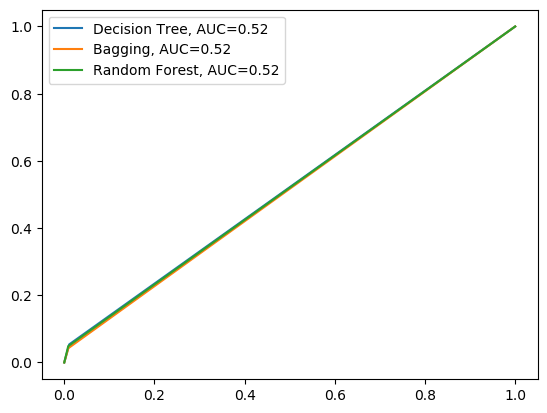

In [102]:
fpr, tpr, _ = metrics.roc_curve(dtree_test_y, dtree_Y_test_pred)
auc = round(metrics.roc_auc_score(dtree_test_y, dtree_Y_test_pred), 2)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(bag_test_y, bagging_Y_test_pred)
auc = round(metrics.roc_auc_score(bag_test_y, bagging_Y_test_pred), 2)
plt.plot(fpr,tpr,label="Bagging, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(rf_test_y, rf_Y_test_pred)
auc = round(metrics.roc_auc_score(rf_test_y, rf_Y_test_pred), 2)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

plt.legend()

### Modeling with imbalance

Modified to include a balance of 15%.
3.18% imbalance

In [103]:
# Train, Valid, Test Split Data
train_size = 438414
valid_size = 125261
test_size = 62631
size = train_size + valid_size + test_size
train, temp = train_test_split(data_le, train_size=train_size, random_state=1)
valid, test = train_test_split(temp, train_size=valid_size, random_state=1)
print('Training Shape & Percentage: ', train.shape, round((train_size/size)*100, 2)) 
print('Validation Shape & Percentage: ', valid.shape, round((valid_size/size)*100, 2))
print('Test Shape & Percentage: ', test.shape, round((test_size/size)*100, 2))

Training Shape & Percentage:  (438414, 7) 70.0
Validation Shape & Percentage:  (125261, 7) 20.0
Test Shape & Percentage:  (62631, 7) 10.0


In [104]:
# Set Variables

X_train = train.drop(['cr_code'], 1) 
Y_train = train['cr_code']

X_val = valid.drop(['cr_code'], 1)
Y_val = valid['cr_code']

X_test = test.drop(['cr_code'], 1)
Y_test = test['cr_code']

In [105]:
# Identify Current Value Counts
print('Train ', train.cr_code.value_counts())
print('Valid ', valid.cr_code.value_counts())
print('Test ', test.cr_code.value_counts())

Train  0    425000
1     13414
Name: cr_code, dtype: int64
Valid  0    121270
1      3991
Name: cr_code, dtype: int64
Test  0    60724
1     1907
Name: cr_code, dtype: int64


In [106]:
# Rebalancing
to_resample = train.loc[train['cr_code'] == 1]
to_resample_val = valid.loc[valid['cr_code'] == 1]
to_resample_test = test.loc[test['cr_code'] == 1]

resample = to_resample.sample(n = 50336, replace = True)
resample_val = to_resample_val.sample(n = 14200, replace = True)
resample_test = to_resample_test.sample(n = 7202, replace = True)

train_rebal = pd.concat([train, resample])
val_rebal = pd.concat([valid, resample_val])
test_rebal = pd.concat([test, resample_test])

print(train_rebal.cr_code.value_counts())
print(val_rebal.cr_code.value_counts())
print(test_rebal.cr_code.value_counts())

0    425000
1     63750
Name: cr_code, dtype: int64
0    121270
1     18191
Name: cr_code, dtype: int64
0    60724
1     9109
Name: cr_code, dtype: int64


In [107]:
# Set Balanced Variables

train_XR = train_rebal.drop(columns=["cr_code", "call_type"])
train_yR = train_rebal[["cr_code"]]

val_XR = val_rebal.drop(columns=["cr_code", "call_type"])
val_yR = val_rebal[["cr_code"]]

test_XR = test_rebal.drop(columns=["cr_code", "call_type"])
test_yR = test_rebal[["cr_code"]]

In [108]:
def modeling_bal(X_train, Y_train, X_val, Y_val, X_test, Y_test, model,model_name):
    """
    Step1 - Dividing the data into train, test, validation sets
    """
    
    Model = model
    Model.fit(X_train,Y_train)
    Y_train_pred = Model.predict(X_train)
    Y_val_pred = Model.predict(X_val)
    Y_test_pred = Model.predict(X_test)

    train_acc = accuracy_score(Y_train,Y_train_pred)
    val_acc = accuracy_score(Y_val,Y_val_pred)
    test_acc = accuracy_score(Y_test,Y_test_pred)
    
    train_recall = recall_score(Y_train,Y_train_pred,average="weighted")
    val_recall = recall_score(Y_val,Y_val_pred,average="weighted")
    test_recall = recall_score(Y_test,Y_test_pred,average="weighted")
    
    train_precision = precision_score(Y_train,Y_train_pred,average="weighted")
    val_precision = precision_score(Y_val,Y_val_pred,average="weighted")
    test_precision = precision_score(Y_test,Y_test_pred,average="weighted")
    
    train_f1 = f1_score(Y_train,Y_train_pred,average="weighted")
    val_f1 = f1_score(Y_val,Y_val_pred,average="weighted")
    test_f1 = f1_score(Y_test,Y_test_pred,average="weighted")
    
    df = pd.DataFrame({"TrainAccuracy":train_acc,"ValidationAccuracy":val_acc,"TestAccuracy":test_acc,
                       "TrainPrecision":train_precision,"ValidationPrecision":val_precision,"TestPrecision":test_precision,
                       "TrainRecall":train_recall,"ValidationRecall":val_recall,"TestRecall":test_recall,
                       "TrainF1":train_f1,"ValidationF1":val_f1,"TestF1":test_f1},
                     index = [model_name])
    
    return Model, Y_test_pred, df

In [109]:
rebal_dtree_model, dtree_Y_pred, rebalanced_dtree_df = modeling_bal(train_XR,
                    train_yR,
                    val_XR,
                    val_yR,
                    test_XR,
                    test_yR,
                    model=DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 1, max_features = None, random_state = 42),
                    model_name = "DecisionTree")

rebal_bagging_model, bagging_Y_pred, rebalanced_bagging_df = modeling_bal(train_XR,
                    train_yR,
                    val_XR,
                    val_yR,
                    test_XR,
                    test_yR,
                    model=BaggingClassifier(max_samples = 0.5, max_features = 0.5),
                    model_name = "Bagging")

rebal_rf_model, rf_Y_pred, rebalanced_rf_df = modeling_bal(train_XR,
                    train_yR,
                    val_XR,
                    val_yR,
                    test_XR,
                    test_yR,
                    model=RandomForestClassifier(n_estimators = 100, random_state = 1),
                    model_name = "RandomForest")

In [110]:
models_df_rebalanced_data = pd.concat([rebalanced_dtree_df,rebalanced_rf_df,rebalanced_bagging_df])
models_df_rebalanced_data.sort_values(by=["TestAccuracy","TestF1"],ascending=False,inplace=True)

models_df_rebalanced_data

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
Bagging,0.869565,0.869562,0.869560,0.756144,0.756138,0.756135,0.869565,0.869562,0.869560,0.808898,0.808893,0.808891
DecisionTree,0.946163,0.846108,0.848582,0.945797,0.804337,0.807571,0.946163,0.846108,0.848582,0.945971,0.819861,0.822303
RandomForest,0.946154,0.845677,0.846949,0.946797,0.804585,0.805287,0.946154,0.845677,0.846949,0.946454,0.819961,0.820597


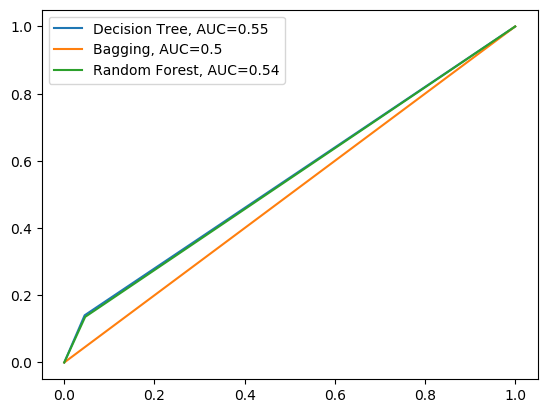

In [111]:
fpr, tpr, _ = metrics.roc_curve(test_yR, dtree_Y_pred)
auc = round(metrics.roc_auc_score(test_yR, dtree_Y_pred), 2)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(test_yR, bagging_Y_pred)
auc = round(metrics.roc_auc_score(test_yR, bagging_Y_pred), 2)
plt.plot(fpr,tpr,label="Bagging, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(test_yR, rf_Y_pred)
auc = round(metrics.roc_auc_score(test_yR, rf_Y_pred), 2)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

plt.legend()

In [ ]:
def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': test_yR,  
        'prob': model.predict(test_XR)
        })
    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    ax = gainsChart(result.actual, label = title, ax=ax, figsize=[12, 8], color = color)
    ax.set_title(title)
    return ax

ax = modelGainsChart(rebal_dtree_model, 'Decision Tree') 
modelGainsChart(rebal_bagging_model, 'Bagging', ax) 
modelGainsChart(rebal_rf_model, 'Random Forest', ax)

ax.set_title('All models')
ax.set_xlabel('# of records')
ax.set_ylabel('Cumulative gains')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Upsampling Method to 50/50

In [113]:
from sklearn.utils import resample

# Separate crisis response codes from non-related codes

mcrt = train.loc[train['cr_code'] == 0]
not_mcrt = train.loc[train['cr_code'] == 1]

mcrt_val = valid.loc[valid['cr_code'] == 0]
not_mcrt_val = valid.loc[valid['cr_code'] == 1]

mcrt_test = test.loc[test['cr_code'] == 0]
not_mcrt_test = test.loc[test['cr_code'] == 1]

# upsample crisis response codes
upsample = resample(not_mcrt, replace = True, n_samples=len(mcrt), random_state = 42)
upsample_val = resample(not_mcrt_val, replace = True, n_samples=len(mcrt_val), random_state = 42)
upsample_test = resample(not_mcrt_test, replace = True, n_samples=len(mcrt_test), random_state = 42)


train_upsampled = pd.concat([mcrt, upsample])
val_upsampled = pd.concat([mcrt_val, upsample_val])
test_upsampled = pd.concat([mcrt_test, upsample_test])

print(train_upsampled.cr_code.value_counts())
print(val_upsampled.cr_code.value_counts())
print(test_upsampled.cr_code.value_counts())

0    425000
1    425000
Name: cr_code, dtype: int64
0    121270
1    121270
Name: cr_code, dtype: int64
0    60724
1    60724
Name: cr_code, dtype: int64


In [114]:
# Set Balanced Variables

train_XU = train_upsampled.drop(columns=["cr_code", "call_type"])
train_yU = train_upsampled[["cr_code"]]

val_XU = val_upsampled.drop(columns=["cr_code", "call_type"])
val_yU = val_upsampled[["cr_code"]]

test_XU = test_upsampled.drop(columns=["cr_code", "call_type"])
test_yU = test_upsampled[["cr_code"]]

In [115]:
upsampled_dtree_model, dtree_Y_predU, upsampled_dtree_df = modeling_bal(train_XU,
                    train_yU,
                    val_XU,
                    val_yU,
                    test_XU,
                    test_yU,
                    model=DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 1, max_features = None, random_state = 42),
                    model_name = "DecisionTree")

upsampled_bagging_model, bagging_Y_predU, upsampled_bagging_df = modeling_bal(train_XU,
                    train_yU,
                    val_XU,
                    val_yU,
                    test_XU,
                    test_yU,
                    model=BaggingClassifier(max_samples = 0.5, max_features = 0.5),
                    model_name = "Bagging")

upsampled_rf_model, rf_Y_predU, upsampled_rf_df = modeling_bal(train_XU,
                    train_yU,
                    val_XU,
                    val_yU,
                    test_XU,
                    test_yU,
                    model=RandomForestClassifier(n_estimators = 100, random_state = 1),
                    model_name = "RandomForest")

In [116]:
models_df_upsampled_data = pd.concat([upsampled_dtree_df,upsampled_rf_df,upsampled_bagging_df])
models_df_upsampled_data.sort_values(by=["TestAccuracy","TestF1"],ascending=False,inplace=True)

models_df_upsampled_data

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
Bagging,0.787040,0.686270,0.696776,0.799319,0.686280,0.696955,0.787040,0.686270,0.696776,0.784833,0.686266,0.696707
DecisionTree,0.955012,0.567741,0.573661,0.958570,0.621181,0.629253,0.955012,0.567741,0.573661,0.954924,0.514181,0.522296
RandomForest,0.955011,0.569613,0.570532,0.958594,0.624088,0.626346,0.955011,0.569613,0.570532,0.954923,0.516555,0.517214


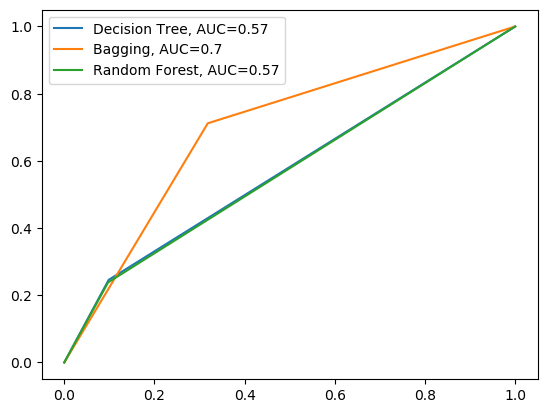

In [117]:
fpr, tpr, _ = metrics.roc_curve(test_yU, dtree_Y_predU)
auc = round(metrics.roc_auc_score(test_yU, dtree_Y_predU), 2)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(test_yU, bagging_Y_predU)
auc = round(metrics.roc_auc_score(test_yU, bagging_Y_predU), 2)
plt.plot(fpr,tpr,label="Bagging, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(test_yU, rf_Y_predU)
auc = round(metrics.roc_auc_score(test_yU, rf_Y_predU), 2)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

plt.legend()

### Models Trained with whole data

In [118]:
models_df_total_data = pd.concat([dtree_df,rf_df,bagging_df])
models_df_total_data

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
DecisionTree,0.977887,0.960914,0.962088,0.977544,0.944328,0.946310,0.977887,0.960914,0.962088,0.972151,0.951882,0.953445
RandomForest,0.977871,0.962479,0.963543,0.976473,0.944865,0.946260,0.977871,0.962479,0.963543,0.972614,0.952668,0.953920
Bagging,0.976099,0.962606,0.962727,0.972738,0.945387,0.945743,0.976099,0.962606,0.962727,0.970729,0.952940,0.953417


In [119]:
models_df_total_data.sort_values(by=["ValidationAccuracy","ValidationF1"],ascending=False,inplace=True)
models_df_total_data

,TrainAccuracy,ValidationAccuracy,TestAccuracy,TrainPrecision,ValidationPrecision,TestPrecision,TrainRecall,ValidationRecall,TestRecall,TrainF1,ValidationF1,TestF1
Bagging,0.976099,0.962606,0.962727,0.972738,0.945387,0.945743,0.976099,0.962606,0.962727,0.970729,0.952940,0.953417
RandomForest,0.977871,0.962479,0.963543,0.976473,0.944865,0.946260,0.977871,0.962479,0.963543,0.972614,0.952668,0.953920
DecisionTree,0.977887,0.960914,0.962088,0.977544,0.944328,0.946310,0.977887,0.960914,0.962088,0.972151,0.951882,0.953445


In [120]:
print("Best Model with default parameters = ".upper(),models_df_total_data.index[0],end="\n")
print("with model validation accuracy = ".upper(),models_df_total_data.ValidationAccuracy[0], end="\n")
print("with model validation precision = ".upper(),models_df_total_data.ValidationPrecision[0], end="\n")
print("with model validation recall = ".upper(),models_df_total_data.ValidationRecall[0], end="\n")
print("with model validation f1score = ".upper(),models_df_total_data.ValidationF1[0], end=" ")

BEST MODEL WITH DEFAULT PARAMETERS =  Bagging
WITH MODEL VALIDATION ACCURACY =  0.9626063770337373
WITH MODEL VALIDATION PRECISION =  0.9453867434422651
WITH MODEL VALIDATION RECALL =  0.9626063770337373
WITH MODEL VALIDATION F1SCORE =  0.9529402133656835 

### Hyperparameter Tuning

### Random Forest

In [121]:
parameters ={'max_depth': [10, 20],
     'criterion' : ['gini', 'entropy'],
     'max_features': [0.3,0.5],
     'min_samples_leaf': [3,5,7],
     'min_samples_split': [2,5],
     'n_estimators': [50,100]}

param_size = ParameterGrid(parameters)

In [122]:
grid_search = RandomForestClassifier()
grid_search = GridSearchCV(
    grid_search, 
    parameters, 
    cv=5,
    scoring='accuracy',n_jobs=-1)

X_train,X_val,Y_train,Y_val = train_test_split(data_le_X.iloc[:50000],data_le_Y.iloc[0:50000],test_size=0.1,random_state=50)
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=50)

grid_result= grid_search.fit(X_train, Y_train)
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Best Score:  1.0


### Randomized CV

In [123]:
random_search=RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions=parameters,verbose=1, n_jobs=-1,
                            n_iter=200)
random_result = random_search.fit(X_train, Y_train)
print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.1min finished


Best Score:  100.0
Best Params:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.3, 'max_depth': 10, 'criterion': 'gini'}


### Bayesian Model Optimization using HyperOpt

In [124]:
def accuracy_model(params):
   clf = RandomForestClassifier(**params)
   return cross_val_score(clf, X_train, Y_train).mean()

param_space = {'max_depth': hp.choice('max_depth', range(10,100)),
'max_features': hp.uniform('max_features', 0.1,1),
'n_estimators': hp.choice('n_estimators', range(50,500)),
'min_samples_leaf': hp.choice('min_samples_leaf',range(3,5)),
'min_samples_split': hp.choice('min_samples_split',range(2,10)),
'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0

def f(params):
    global best
    acc = accuracy_model(params)
    if acc > best:
        best = acc
    return {'loss': -acc, 'status': STATUS_OK}

Trials = Trials()
best_params = fmin(f, param_space , algo=tpe.suggest,max_evals=5, trials= Trials)
print('New best:', best, best_params)
print(best_params)

100%|██████████| 5/5 [00:21<00:00,  4.35s/trial, best loss: -1.0]
New best: 1.0 {'criterion': 0, 'max_depth': 1, 'max_features': 0.6888187447800528, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 247}
{'criterion': 0, 'max_depth': 1, 'max_features': 0.6888187447800528, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 247}
